In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

plt.style.use('ggplot')

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package punkt_tab to /Users/danc/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /Users/danc/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danc/nltk_data...


In [ ]:
#from huggingface_hub import notebook_login
#notebook_login()

In [2]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("imdb")

# Inspect dataset features
ds_builder.info.features

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [3]:
# Load the IMDb dataset from Hugging Face
from datasets import load_dataset
imdb = load_dataset("imdb")

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# check the dataset split names
from datasets import get_dataset_split_names
get_dataset_split_names("imdb")

['train', 'test', 'unsupervised']

In [5]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
ds_train = imdb['train']
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

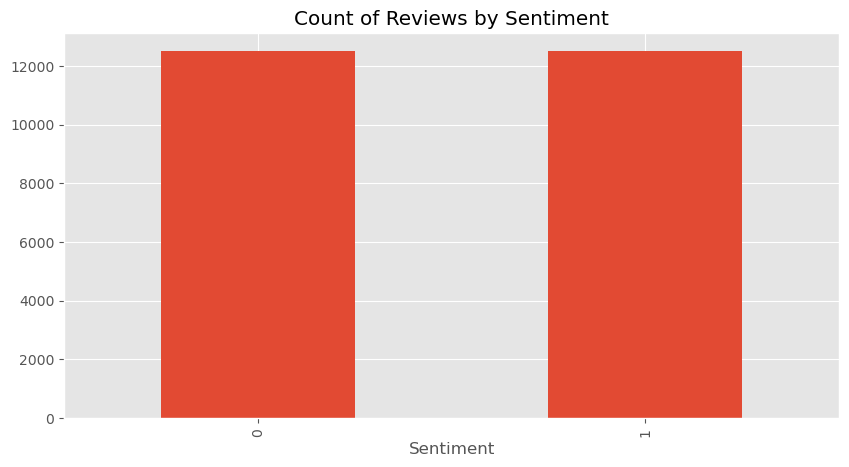

In [7]:
# EDA
# check the distribution of the labels
labels_train = pd.Series(ds_train['label'])
ax = labels_train.value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()

In [8]:
# basic NLTK preprocessing
example_text = ds_train[0]['text']
example_text
tokens = nltk.word_tokenize(example_text)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  rented/VBD
  I/PRP
  AM/VBP
  CURIOUS-YELLOW/JJ
  from/IN
  my/PRP$
  video/NN
  store/NN
  because/IN
  of/IN
  all/PDT
  the/DT
  controversy/NN
  that/WDT
  surrounded/VBD
  it/PRP
  when/WRB
  it/PRP
  was/VBD
  first/RB
  released/VBN
  in/IN
  1967/CD
  ./.
  I/PRP
  also/RB
  heard/VBD
  that/IN
  at/IN
  first/JJ
  it/PRP
  was/VBD
  seized/VBN
  by/IN
  (GPE U.S./NNP)
  customs/NNS
  if/IN
  it/PRP
  ever/RB
  tried/VBD
  to/TO
  enter/VB
  this/DT
  country/NN
  ,/,
  therefore/RB
  being/VBG
  a/DT
  fan/NN
  of/IN
  films/NNS
  considered/VBN
  ``/``
  controversial/JJ
  ''/''
  I/PRP
  really/RB
  had/VBD
  to/TO
  see/VB
  this/DT
  for/IN
  myself./NN
  </NNP
  br/NN
  //NNP
  >/NNP
  </NNP
  br/NN
  //NNP
  >/VBZ
  The/DT
  plot/NN
  is/VBZ
  centered/VBN
  around/IN
  a/DT
  young/JJ
  (GPE Swedish/JJ)
  drama/NN
  student/NN
  named/VBN
  (PERSON Lena/NNP)
  who/WP
  wants/VBZ
  to/TO
  learn/VB
  everything/NN
  she/PRP
  can/MD
  about/IN
  life/NN
  ./

In [9]:
# VADER (Valence Aware Dictionary and Sentiment Reasoner), ignoring contexts
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example_text)

{'neg': 0.04, 'neu': 0.922, 'pos': 0.038, 'compound': -0.1167}

In [10]:
# Run the polarity score on the entire training dataset
results_train = {}
counter = 0
for row in tqdm(ds_train, total=len(ds_train)):
    text = row['text']
    results_train[counter] = sia.polarity_scores(text)
    counter += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

In [11]:
vaders = pd.DataFrame(results_train).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders


,Id,neg,neu,pos,compound
0,0,0.040,0.922,0.038,-0.1167
1,1,0.085,0.869,0.046,-0.8648
2,2,0.068,0.798,0.133,0.8324
3,3,0.127,0.749,0.124,-0.0924
4,4,0.083,0.876,0.041,-0.9358
...,...,...,...,...,...
24995,24995,0.098,0.716,0.186,0.9136
24996,24996,0.116,0.744,0.140,0.6056
24997,24997,0.072,0.684,0.244,0.9799
24998,24998,0.075,0.803,0.122,0.9909


In [12]:
df_train = pd.DataFrame(ds_train)
df_train = df_train.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_train, how='left')
vaders

,Id,neg,neu,pos,compound,text,label
0,0,0.040,0.922,0.038,-0.1167,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,1,0.085,0.869,0.046,-0.8648,"""I Am Curious: Yellow"" is a risible and preten...",0
2,2,0.068,0.798,0.133,0.8324,If only to avoid making this type of film in t...,0
3,3,0.127,0.749,0.124,-0.0924,This film was probably inspired by Godard's Ma...,0
4,4,0.083,0.876,0.041,-0.9358,"Oh, brother...after hearing about this ridicul...",0
...,...,...,...,...,...,...,...
24995,24995,0.098,0.716,0.186,0.9136,A hit at the time but now better categorised a...,1
24996,24996,0.116,0.744,0.140,0.6056,I love this movie like no other. Another time ...,1
24997,24997,0.072,0.684,0.244,0.9799,This film and it's sequel Barry Mckenzie holds...,1
24998,24998,0.075,0.803,0.122,0.9909,'The Adventures Of Barry McKenzie' started lif...,1


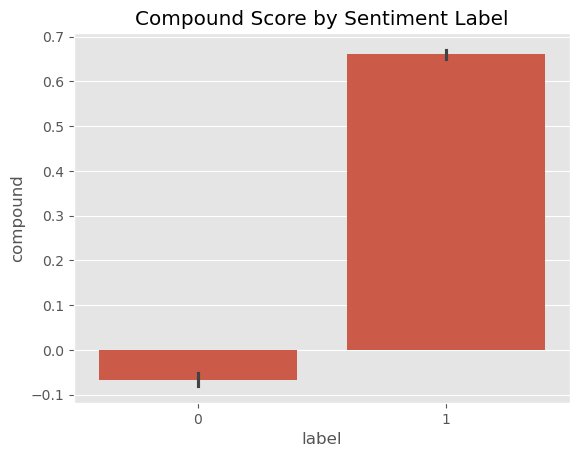

In [13]:
# plot VADER scores by sentiment label
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compound Score by Sentiment Label')
plt.show()

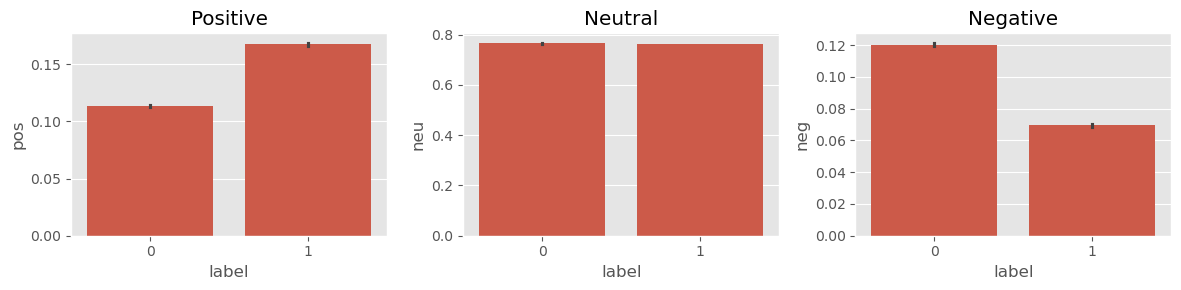

In [14]:
# plot VADER sub-scores by sentiment label
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [15]:
# Use the Roberta pretrained model for sentiment analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [16]:
# Get the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [17]:
# Run the example text through the Roberta model and get the scores
encoded_text = tokenizer(example_text, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.5537569,
 'roberta_neu': 0.37692472,
 'roberta_pos': 0.069318384}

In [18]:
# Make a function to run the Roberta model on each entry
def polarity_scores_roberta(example):
    # Tokenize with truncation
    encoded_text = tokenizer(
        example, 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=512
    )
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    print(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [19]:
# Test the function on the example text
polarity_scores_roberta(example_text)

[0.5537569  0.37692472 0.06931838]


{'roberta_neg': 0.5537569,
 'roberta_neu': 0.37692472,
 'roberta_pos': 0.069318384}

In [20]:
# Run the Roberta model on the training dataset
results_train_both = {}
counter = 0

for row in tqdm(ds_train, total=len(ds_train)):
    try:
        text = row['text']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        results_train_both[counter] = both
        counter += 1
    except RuntimeError:
        print(f'Broke for row {counter}')

  0%|          | 0/25000 [00:00<?, ?it/s]

[0.5537569  0.37692472 0.06931838]
[0.7618614  0.2169006  0.02123803]
[0.368857   0.41600502 0.21513793]
[0.8524133  0.12718567 0.02040094]
[0.60797256 0.3305043  0.06152314]
[0.926802   0.06420989 0.00898811]
[0.89897835 0.09106185 0.00995985]
[0.7489823  0.2091942  0.04182346]
[0.37930107 0.42227516 0.1984238 ]
[0.4801115  0.4083624  0.11152609]
[0.23229182 0.41433203 0.3533761 ]
[0.64025915 0.2829     0.07684088]
[0.9461116  0.04713557 0.00675282]
[0.50949335 0.39164922 0.09885743]
[0.18146214 0.402571   0.41596684]
[0.9658897  0.02991473 0.00419557]
[0.7961195  0.16156326 0.04231723]
[0.54639244 0.34897074 0.10463683]
[0.97323215 0.02293918 0.00382872]
[0.954144   0.04096574 0.00489022]
[0.62718123 0.31836626 0.05445253]
[0.31540057 0.4215717  0.26302773]
[0.81703424 0.1557551  0.02721067]
[0.49977627 0.38827163 0.11195213]
[0.95676965 0.03758922 0.00564106]
[0.8821828  0.1032147  0.01460254]
[0.9385184  0.05476997 0.00671156]
[0.75308704 0.1768623  0.07005073]
[0.6656983  0.257259

In [32]:
# try to run the model on Mac GPUs
import torch
#from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Check if MPS (Metal Performance Shaders) is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [34]:
# Load the tokenizer and model
model = model.to(device)

# Tokenize the input
inputs = tokenizer(example_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get predictions
predicted_class = torch.argmax(logits, dim=1).item()
print(example_text)
print(f"Predicted class: {predicted_class}")


I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [46]:
# Make a function to run the Roberta model on the GPUs
def polarity_scores_roberta_gpu(example):
    # Tokenize with truncation
    encoded_text = tokenizer(
        example, 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=512
    ).to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**encoded_text)
        #logits = outputs.logits

    # Get predictions
    scores = outputs[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    #print(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [47]:
# Test the function on the example text
polarity_scores_roberta_gpu(example_text)

{'roberta_neg': 0.5537572,
 'roberta_neu': 0.37692443,
 'roberta_pos': 0.069318324}

In [48]:
# Run the Roberta model on the training dataset using GPUs
results_train_both = {}
counter = 0

for row in tqdm(ds_train, total=len(ds_train)):
    try:
        text = row['text']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta_gpu(text)
        both = {**vader_result_rename, **roberta_result}
        results_train_both[counter] = both
        counter += 1
    except RuntimeError:
        print(f'Broke for row {counter}')

  0%|          | 0/25000 [00:00<?, ?it/s]

In [49]:
results_df = pd.DataFrame(results_train_both).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df_train, how='left')
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,text,label
0,0,0.040,0.922,0.038,-0.1167,0.553757,0.376924,0.069318,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,1,0.085,0.869,0.046,-0.8648,0.761862,0.216900,0.021238,"""I Am Curious: Yellow"" is a risible and preten...",0
2,2,0.068,0.798,0.133,0.8324,0.368858,0.416005,0.215137,If only to avoid making this type of film in t...,0
3,3,0.127,0.749,0.124,-0.0924,0.852413,0.127186,0.020401,This film was probably inspired by Godard's Ma...,0
4,4,0.083,0.876,0.041,-0.9358,0.607972,0.330504,0.061523,"Oh, brother...after hearing about this ridicul...",0
...,...,...,...,...,...,...,...,...,...,...
24995,24995,0.098,0.716,0.186,0.9136,0.415661,0.437927,0.146412,A hit at the time but now better categorised a...,1
24996,24996,0.116,0.744,0.140,0.6056,0.181630,0.351952,0.466418,I love this movie like no other. Another time ...,1
24997,24997,0.072,0.684,0.244,0.9799,0.004500,0.018533,0.976966,This film and it's sequel Barry Mckenzie holds...,1
24998,24998,0.075,0.803,0.122,0.9909,0.212236,0.576408,0.211356,'The Adventures Of Barry McKenzie' started lif...,1


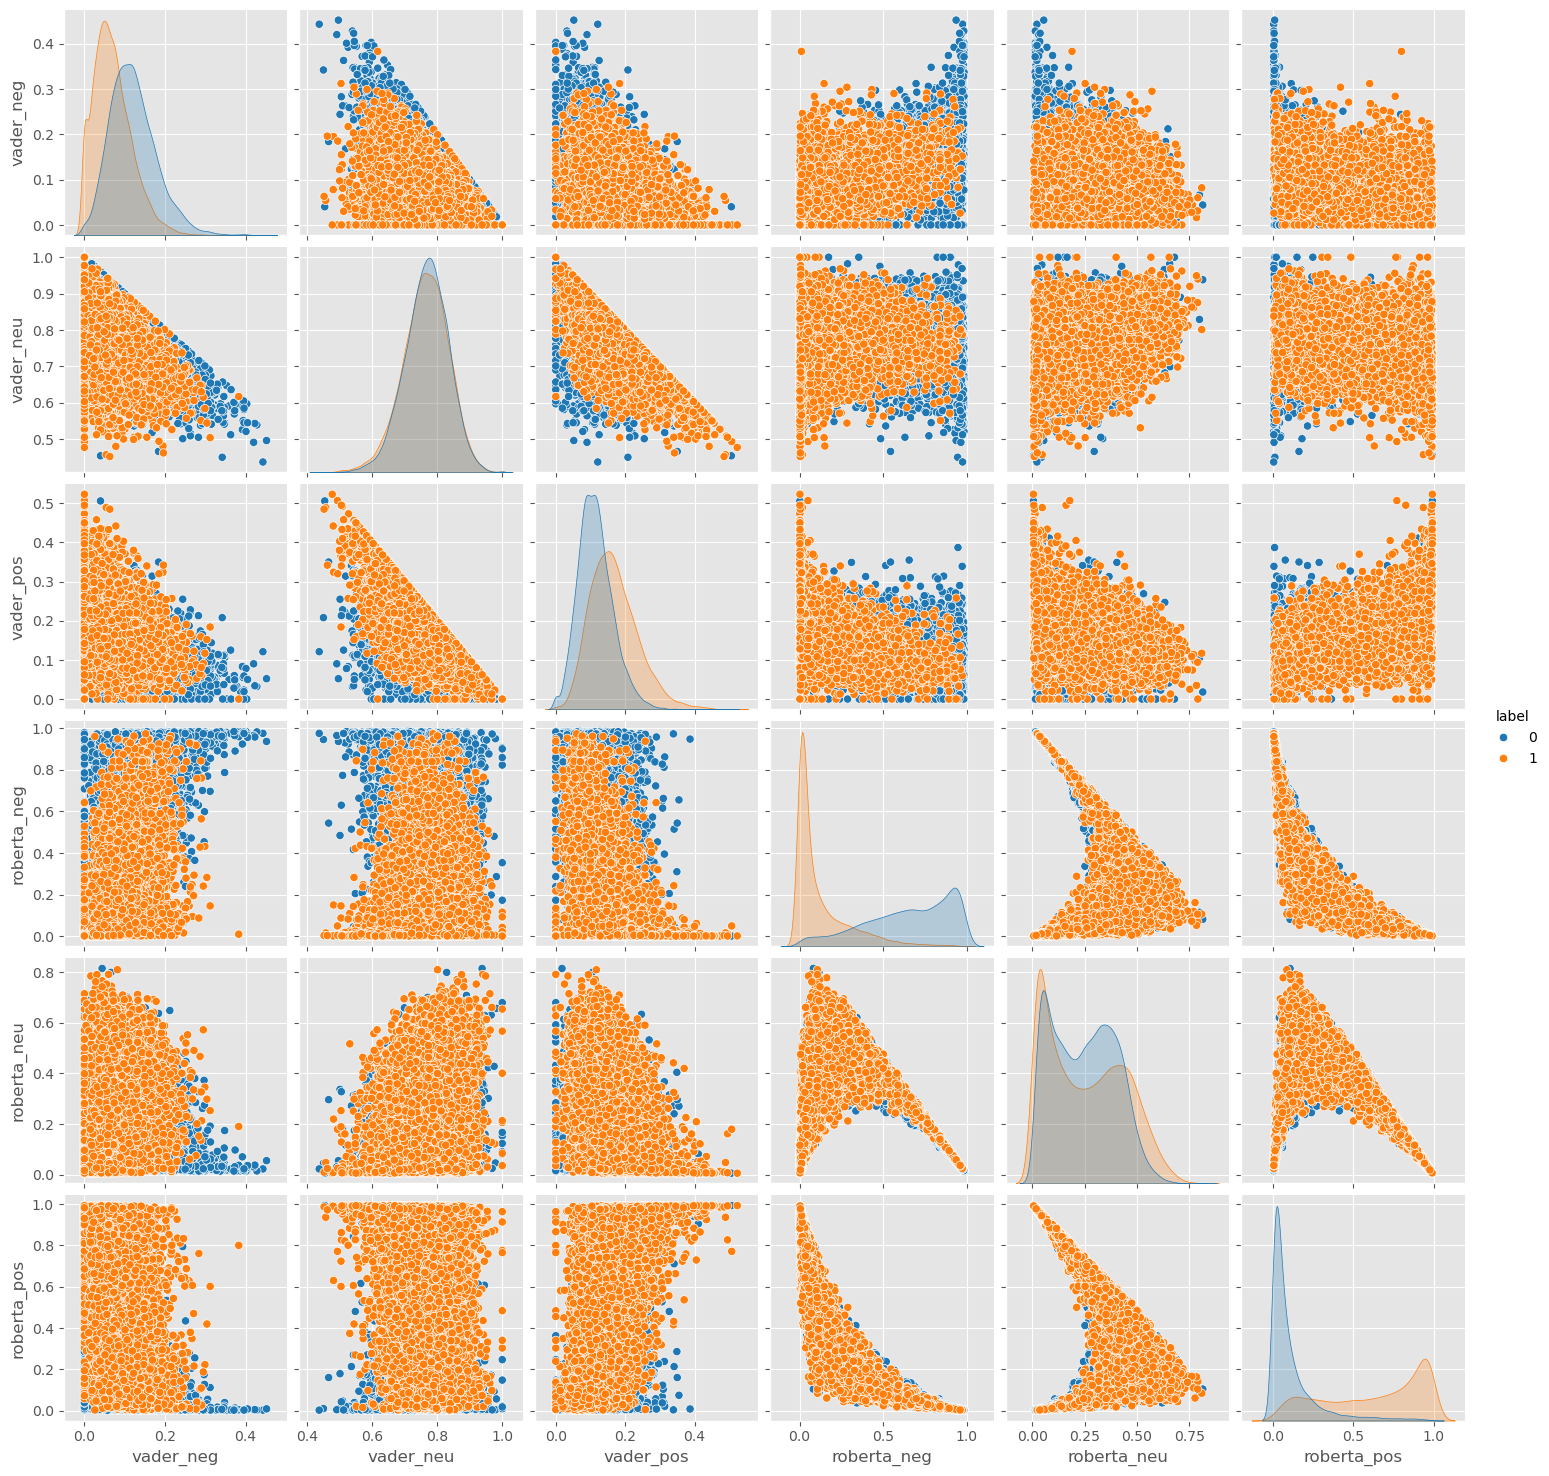

In [22]:
# compare the VADER and Roberta scores
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='label',
            palette='tab10')
plt.show()

In [23]:
# sanity check the VADER and Roberta scores
results_df.query('label == 0') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0]

"this is a great movie. I love the series on tv and so I loved the movie. One of the best things in the movie is that Helga finally admits her deepest darkest secret to Arnold!!! that was great. i loved it it was pretty funny too. It's a great movie! Doy!!!"

In [24]:
results_df.query('label == 0') \
    .sort_values('vader_pos', ascending=False)['text'].values[0]

"this is a great movie. I love the series on tv and so I loved the movie. One of the best things in the movie is that Helga finally admits her deepest darkest secret to Arnold!!! that was great. i loved it it was pretty funny too. It's a great movie! Doy!!!"

In [25]:
results_df.query('label == 1') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0]

'....after 16 years Tim Burton finally disappoints me!!!! Whatever happened to the old Burton who read "The Dark Knight Returns" by Frank Miller as research for his preparation to direct Batman back in 1988-89? By the looks of it Burton didn\'t research the book nor the movie cause he got everything WRONG! This movie sucks! It\'s not as good as the original and it doesn\'t deal with the same subject as the original. If you want a good ape movie watch the original.<br /><br />**out of****stars'

In [26]:
results_df.query('label == 1') \
    .sort_values('vader_neg', ascending=False)['text'].values[0]

'This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments.'

In [27]:
# Use the Transformers Pipeline for sentiment analysis
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0


In [28]:
sent_pipeline(example_text)

[{'label': 'POSITIVE', 'score': 0.7872856259346008}]

In [29]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [30]:
sent_pipeline('I hate having no gpus!')

[{'label': 'NEGATIVE', 'score': 0.9979090690612793}]

In [31]:
sent_pipeline('What a beautiful day! All my clothes got wet!')

[{'label': 'POSITIVE', 'score': 0.9995508790016174}]

In [ ]:
# randomize the test set
ds_test = imdb['test']
ds_test


In [ ]:
# split a validation set from the test set
